# In class exercises for 11.21.2018 (Filtering)

## First import data from eeg_data00.npz

In [1]:
# first import the modules that you'll need. 
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# import our sinc filter implementation function...
import my_sinc_filt as msf

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

## Just like in the first FFT tutorial load eeg_data00.npz so that we have an EEG data set to play with
* you should find that it has three arrays: data, tx, and sr (with 'data' a #trials x # timepoints array containing the EEG data, the time of each data acquisition in tx, and the sample rate stored as sr).  

In [2]:
# load the data...
eeg = np.load('eeg_data00.npz')

# get the different arrays like this...kind of like a structure in matlab. 
eeg['data']
eeg['sr']
eeg['tx']

# and can query the attributes of the data like this...which will tell us that there 960 trials and 876 timepoints per trial sampled
# at 250Hz
print('Shape of the big eeg data set: ', eeg['data'].shape)
print('Sample rate: ', eeg['sr'])

# and if you want to save some typing, especially because we only have a few variables, you reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']
# now you can just write data instead of eeg['data'] (and can for tx and sr as well...)

Shape of the big eeg data set:  (960, 876)
Sample rate:  250


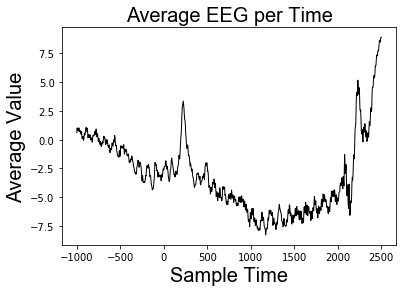

Yep, mean plot still looks like it did before...
(876,)


In [23]:
#data plot
mean_data = np.mean(data,0)
plt.plot(tx, mean_data, 'k-', linewidth = 1)
plt.xlabel('Sample Time',fig_font)
plt.ylabel('Average Value', fig_font)
plt.title('Average EEG per Time', fig_font)
plt.show()
print('Yep, mean plot still looks like it did before...')
print(mean_data.shape)

## Extract the data from time 0 until time 2000
* hint: you can use boolean indexing by selecting the columns from the 'data' matrix that meet: (tx>=0)  & (tx<2000)
* while you're at it, go ahead and grab the timepoints corresponding to that interval as well

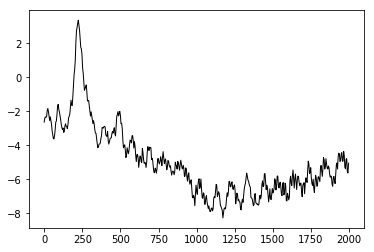

Good, restricted mean looks like before, too


In [8]:
#select columns 
seg_data = data[:, (tx>=0)& (tx<2000)]
#get timepoints, too
seg_time = tx[(tx>=0)&(tx<2000)]
#check plot of newly resticted mean
mean_data = np.mean(seg_data,0)
plt.plot(seg_time, mean_data, 'k-', linewidth = 1)
plt.show()
print('Good, restricted mean looks like before, too')

## Then FFT each trial and take a look at the average power across frequencies
* FFT each trial 
* Then compute the amplitude on each trial
* Then compute the average amplitude across all trials

In [9]:
#new storage
r,c = seg_data.shape
#FFT each trial
sp = np.fft.rfft(seg_data, axis=1)

In [10]:
#amplitude
amp = np.abs(sp)
amp = (amp/c)*2
mean_amp = np.mean(amp, axis=0)

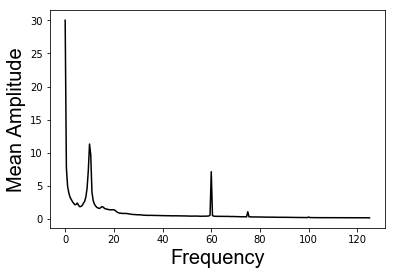

In [11]:
#across frequencies
dt = 1/sr
freq = np.fft.rfftfreq(c, dt)

#plot
plt.plot(freq, mean_amp, 'k-')
plt.xlabel('Frequency', fig_font)
plt.ylabel('Mean Amplitude', fig_font)
plt.show()

## Notice that there are two prominent features in the freq domain representation. Make a lp filter that gets rid of power > 20Hz (you'll know if it worked if you get rid of the spike at 60Hz)
* Because our apply_filter function isn't optimized to work on matrices (we could do that, but haven't) you will need to loop and apply filter to each trial

In [12]:
#cutoff frequency
fc=0.1
#transition band
b=0.1
#window
window = 'blackman'
type_filter = 'lp'
#generate low-pass filter
n, sinc_func = msf.define_filt(fc=fc, b=b, window=window, type_filt=type_filter)
#filter
filtered_signal = np.zeros((r,c))
for i in np.arange(r):
    filtered_signal[i,:] = msf.apply_filt(input_sig=seg_data[i,:], input_filter=sinc_func)

## Then FFT it again to see if you got rid of the hf components of the signal

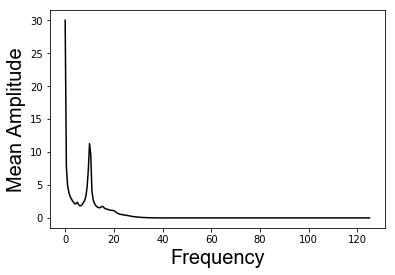

In [13]:
#new storage
r,c = filtered_signal.shape
#FFT
sp = np.fft.rfft(filtered_signal, axis=1)
#amplitude
amp = np.abs(sp)
amp = (amp/c)*2
mean_amp = np.mean(amp, axis=0)
#frequency
dt = 1/sr
freq = np.fft.rfftfreq(c, dt)
#plot
plt.plot(freq, mean_amp, 'k-')
plt.xlabel('Frequency', fig_font)
plt.ylabel('Mean Amplitude', fig_font)
plt.show()

## Now design a band pass filter that gets rid of everything outside of the 6-14Hz range (where that big bump is...)
* To design a band pass filter, make a lp filter (with an appropriate fc), then make a hp filter (with an appropriate fc)
* use np.convolve to combine the two filters 
* then call the apply_filt function
* Then you should be left with only those frequencies that pass the lp and the hp filters (i.e. a band pass filter)!

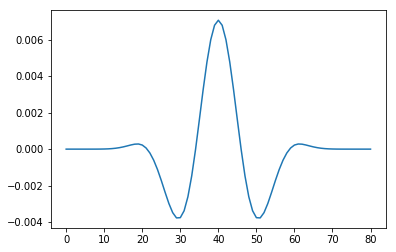

In [20]:
#range
bp_filter = [6,14]
freqs=bp_filter/sr

#low pass
fc = freqs[0]
b=0.1
window = 'blackman'
type_filter = 'lp'
#generate the low-pass filter
n, sinc_func_1 = msf.define_filt(fc=fc, b=b, window=window, type_filt=type_filter)

#high pass
fc = freqs[1]
b=0.1
window = 'blackman'
type_filter = 'hp'
#generate high pass filter
n, sinc_func_2 = msf.define_filt(fc=fc, b=b, window=window, type_filt=type_filter)

#combine the filters
comb_filters = np.convolve(sinc_func_1, sinc_func_2)
#apply filter
filtered_signal = np.zeros((r,c))
for i in np.arange(r):
    filtered_signal[i,:] = msf.apply_filt(input_sig=seg_data[i,:], input_filter=comb_filters)
plt.plot(comb_filters)

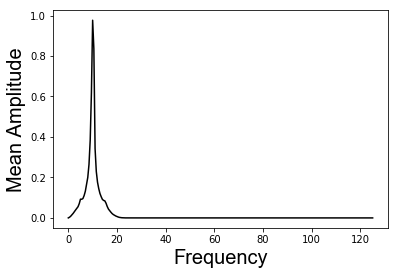

In [21]:
#new storage
r,c = filtered_signal.shape
#FFT
sp = np.fft.rfft(filtered_signal, axis=1)
#amplitude
amp = np.abs(sp)
amp = (amp/c)*2
mean_amp = np.mean(amp, axis=0)
#frequency
dt = 1/sr
freq = np.fft.rfftfreq(c, dt)
#plot
plt.plot(freq, mean_amp, 'k-')
plt.xlabel('Frequency', fig_font)
plt.ylabel('Mean Amplitude', fig_font)
plt.show()

## You can also make a band-stop filter using a similar logic
* Instead of convolving the lp and the hp filters, you can add them together
* Use this to selectively get rid of the 60Hz line noise in the data by generated a band-stop filter over 50-70Hz

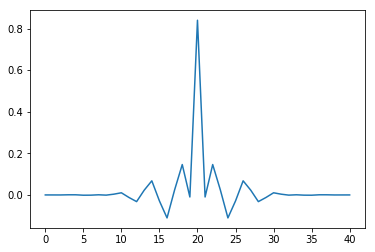

In [24]:
#range
bs_filter = [50,70]
freqs=bs_filter/sr

#low pass
fc = freqs[0]
b=0.1
window = 'blackman'
type_filter = 'lp'
#generate the low-pass filter
n, sinc_func_1 = msf.define_filt(fc=fc, b=b, window=window, type_filt=type_filter)

#high pass
fc = freqs[1]
b=0.1
window = 'blackman'
type_filter = 'hp'
#generate high pass filter
n, sinc_func_2 = msf.define_filt(fc=fc, b=b, window=window, type_filt=type_filter)

#add the filters
add_filters = sinc_func_1 + sinc_func_2
#apply filter
filtered_signal = np.zeros((r,c))
for i in np.arange(r):
    filtered_signal[i,:] = msf.apply_filt(input_sig=seg_data[i,:], input_filter=add_filters)
plt.plot(add_filters)

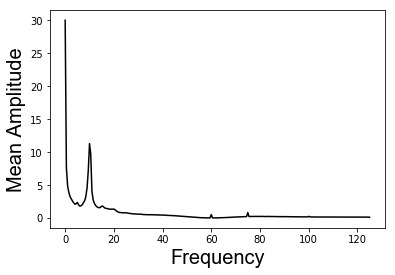

In [25]:
#new storage
r,c = filtered_signal.shape
#FFT
sp = np.fft.rfft(filtered_signal, axis=1)
#amplitude
amp = np.abs(sp)
amp = (amp/c)*2
mean_amp = np.mean(amp, axis=0)
#frequency
dt = 1/sr
freq = np.fft.rfftfreq(c, dt)
#plot
plt.plot(freq, mean_amp, 'k-')
plt.xlabel('Frequency', fig_font)
plt.ylabel('Mean Amplitude', fig_font)
plt.show()

## Then FFT and look at filtered signal in the frequency domain